# Reinforcement Learning using the upwind/downwind/centerline model

![](data/intermittent_smoke_med.gif)

<br>
This repository explores the use of traditional Reinforcement Learning *temporal-difference* methods such as the <a href=https://en.wikipedia.org/wiki/Q-learning> Q-learning </a> algorithm to understand how agents can learn to navigate to the source of a 2D turbulent odor plume. Turbulent odor plumes are spatiotemporally complex: odor signals arrive in random, unpredictable bursts, and odor concentration does follow continuous gradients, making plume navigation a difficult task. Surprisingly, there has been no published work on applying RL algorithms to turbulent odor plume navigation. This notebook will explore a simple model of navigation with a reduced set of states.
<br>
<br>




## Q-learning algorithm
Q-learning updates a state-action value function, $Q(a, s)$, which quantifies the value of taking action $a$ when in state $s$. This function is updated in time using the Q-learning algorithm. At each timestep, the navigator takes an action $A$ to go from state $S$ to state $S'$, using whatever policy (greedy, $\epsilon$-greedy, etc.), where it receives a reward $R$. Then $Q(A, S)$ is updated using a *greedy* update rule (hence *off-policy*):

$\begin{align}
 Q(A, S) \leftarrow Q(A, S) + \alpha[R + \gamma \max_a Q(a, S')  - Q(A, S)]
\end{align}$

Here, $\alpha < 1$ and $\gamma < 1$ are learning and reward discount rate -- both hyperparameters in the simulation.

## Model states, actions, and rewards

The *upwind-downwind-centerline* model explored in this notebook is defined by its states and actions.

### State space: $\{s\}$

Following results found recently for navigation of odor plumes by fruit flies, we assume that navigators rely on the frequency of odor hits. An odor hit is the time at which the signal surpassses a given threshold. Running average of hit frequency, $W_{freq}$, is found by convolving the binary time series of odor hit times $w(t)$ with an exponential kernel ($\tau = 2$ seconds):

$W_{freq} = \int^t_{-\infty} e^{-(t-t')/\tau} w(t')dt'$

We discretize the state space by odor hit frequency with partitions $\{a_i\}$.

$S_i$: $a_i < W_{freq} < a_{i+1}$

### Action space: $\{a\}$
The navigators move on a grid, and we assume that there are 4 actions:

$A_1$: turn upwind (i.e. left) 

$A_2$: walk straight

$A_3$: turn toward the plume centerline

$A_4$: turn downwind (i.e. right)

The action $A_3$ means that, in the plume cone, flies in the top half will turn downward, and flies in the bottom half will turn upward. 

### Reward space: $\{r\}$
We assume the rewards are 1 if the navigator is experiencing a plume hit (odor signal is above threshold) and 0 otherwise. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append('src')
from utils import gen_plot
from models import *

## Run the RL simulation

### Instantiate model class
Define number of parallel agents and how many steps in episode

In [2]:
a = centerline_upwind_downwind()
a.num_walkers = 1000
a.num_steps = 5000
a.x0_min = 500
a.xo_max = 1000
a.max_x = 1000
a.y0_spread = 200
a.def_actions()

### Set the frequency partitions defining the states

In [12]:
freq_bins = [-1, 0.5, 2, 7, 100]
a.def_states(freq_bins=freq_bins)

### Run

In [4]:
xs, ys, Q, Q_terminal, path_lengths = a.run()

100.0%

### Plot the Q-function for each state

For all states (all colors), upwind turning is  the optimal action. For high frequency (dark red), upwind turning is stronly preferred. For medium frequency states, there is also a preference for turning toward the centerline. This however is the least favorable option for hight frequency states.  

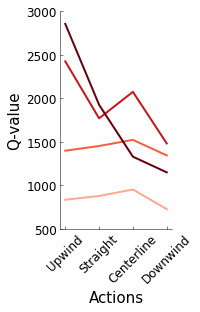

In [5]:
fig, ax = gen_plot(2, 4)
colors = plt.cm.Reds(np.linspace(0.3, 1.0, a._num_states))
for iS in range(a._num_states):
    plt.plot(Q_terminal[iS], color=colors[iS], lw=2)

plt.xlabel('Actions', fontsize=15)
plt.ylabel('Q-value', fontsize=15)
plt.xticks(range(a._num_actions), fontsize=12)
plt.yticks(np.arange(500, 3001, 500), fontsize=12)
ax.set_xticklabels(['Upwind', 'Straight', 'Centerline', 'Downwind'], rotation=45)
plt.show()

### Plot trajectories of virtual navigators during learning
Blue is beginning; yellow is end. Odor source is at middle left (see plume snapshot above)

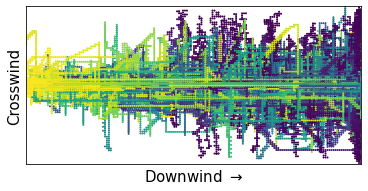

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
for iW in range(a.num_walkers//5):
    colors = plt.cm.viridis(np.linspace(0, 1, path_lengths[iW]))
    plt.scatter(xs[:path_lengths[iW], iW], 
                ys[:path_lengths[iW], iW], 
                c=colors, s=1)

ax.set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Downwind $\rightarrow$', fontsize=15)
plt.ylabel('Crosswind', fontsize=15)
ax.set_xlim(150, 1000)
ax.set_ylim(450 - 200, 450 + 200)
plt.show()

### Plot the softmax action selection of Q-function with temperature $T = 1000$

Now we run the simulation for navigators using the optimal learned policy. There is no learning at this stage -- the $Q$ function is fixed and all navigators are acting according to it. Navigators choose actions with probability $p_T(action|state)$ based on the "softmax" rule, which is based on  the learned $Q$, as such:

\begin{align}
p_{T}(action|state) = \frac{e^{Q(action|states)/T}}{\sum_{actions}e^{Q(action|states)/T}}
\end{align}

First we plot what the probabilities look like for our learned $Q$-function

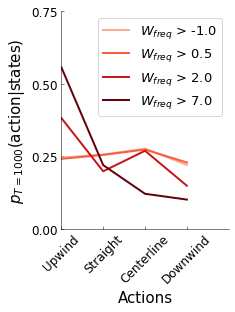

In [18]:
temp = 1000
Q_norm = (np.exp(Q_terminal.T/temp)/np.sum(np.exp(Q_terminal/temp), axis=-1)).T

fig, ax = gen_plot(3, 4)
colors = plt.cm.Reds(np.linspace(0.3, 1.0, a._num_states))
for iS in range(a._num_states):
    plt.plot(Q_norm[iS], color=colors[iS], lw=2, 
             label='$W_{freq}$ > %.1f' % freq_bins[iS])

plt.xlabel('Actions', fontsize=15)
plt.ylabel(r'$p_{T=%s}($action|states)' % temp, fontsize=15)
plt.xticks(range(a._num_actions), fontsize=12)
plt.yticks([0, 0.25, 0.5, 0.75], fontsize=12)
plt.xlim(0, 4)
ax.set_xticklabels(['Upwind', 'Straight', 
                    'Centerline', 'Downwind'], rotation=45)
plt.legend(loc=1, fontsize=13)
plt.show()

### Simulate navigators using learned softmax Q-policy

Next we simulate the agents using the softmax policy. Navigators choose actions that optimize $p_T(actions|state)$, derived from the softmax of $Q$. 

In [11]:
a.num_walkers = 100
a.num_steps = 1000
xs, ys, path_lengths = a.run_optimal_action(Q_terminal, temp=1000)

99.9%

### Plot the navigator trajectories from softmax Q-policy
Note that optimal policy outside of the plume (odor hit frequency is low) is to take random actions with some preference for moving toward the centerline. Once in a region of high hits, the optimal policy is to go upwind, so the navigators move toward the source once in the center of the plume. This is reflected in the trajectories below. 

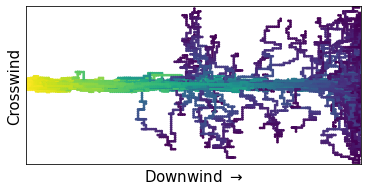

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
for iW in range(a.num_walkers):
    colors = plt.cm.viridis(np.linspace(0, 1, path_lengths[iW]))
    plt.scatter(xs[:path_lengths[iW], iW], 
                ys[:path_lengths[iW], iW], 
                c=colors, s=3)

ax.set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Downwind $\rightarrow$', fontsize=15)
plt.ylabel('Crosswind', fontsize=15)
ax.set_xlim(150, 1000)
ax.set_ylim(450 - 200, 450 + 200)
plt.show()